# Проект: Планирование рекламной компании для интернет магазина "Стримчик".

**Цель:**
* Нам даны различные данные по видео играм, выпущенным до 2016 года. Необходимо спланировать рекламную компанию на 2017 год.

**Данные:**
* Данные, которыми апеллируем: Название, жанр и год выпуска игры, платформы на которых игры выпускались, количество продаж по регионам, оценки пользователей и критиков, а также возрастной рейтинг. 

**План ислледования:**
1. Подготовим данные 
2. Проведем исследовательский анализ:
  * Изучим динамику выпуска игр по годам
  * Изучим динамику продаж на разных платформах
  * Определим актуальный период для анализа
  * Определим платформы, которые лидируют по продажам
  * Изучим распределение значений с помощью "ящика с усами"
  * Определим влияние оценок критиков и пользователей
  * Изучим распределение игр по жанрам, определим прибыльные жанры
3. Составим портрет пользователя
4. Проверим гипотезы о том что:
  * "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"
  * "Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные"
5. Напишем общий вывод


## Шаг 1. Чтение файла и изучение общей информации.


In [1]:
#Импортируем необходимые библиотеки 
import pandas as pd
#import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import stats as st
from math import factorial
from scipy.stats import binom, norm
from math import sqrt

In [3]:
# Формируем датафрей на основе данных
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [4]:
#Изучаемпервые 5 строк сформированного датафрейма
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Изучив первые 5 строк, можно сделать некоторые выводы**:
* Необходимо привести к  'Змеиному регистру'  названия столбцов
* Мы видим, что некоторые строки имеют пропуски в столбцах: 'Critic_Score', 'User_Score', 'Rating', необходимо будет проверить и другие значения на пропуски, в данном случае можно предположить, что пропуски связаны с тем, что игры были выпущены до 20 века и эти метрики к ним не применялись
* Год выпуска необходимо привести к целочисленному значению  

In [8]:
# Смотрим общую информацию по датафрейму
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Изучив общую информацию, мы выявили:**
* Всего в датфрейме 16715 строк
* Есть пропуски в нескольких колонках, необходимо обработать эти колонки, в ином случае удалить их, если это возможно
* Есть колонки с неправильным типом данных, например, Year_of_Release, о котором, мы говорили выше, а также User_Score, который имеет значение object, хотя содержит в себе числовые элементы, необходимо разобраться, с чем это связано

## Шаг 2. Предобработка данных

### Обработка названий столбцов

In [12]:
# Обрабатываем названия столбцов
data.rename(columns=str. lower, inplace=True)

In [13]:
# Смотрим результат
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Выполнено успешно**

### Обработка дубликатов

#### Обработка явных дубликатов

In [17]:
#Ищем дубликаты
data.duplicated().sum()

0

**Явных дубликатов не обнаружено.**

#### Обработка неявных дубликатов

In [20]:
#Ищем неявные дубликаты
data[data.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.0,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.0,83.0,5.5,E


**Мы нашли 2 строки с дубликатами, избавимся от них**

In [22]:
#Удаляем дубликаты
data.drop_duplicates(subset=['name','platform','year_of_release'], inplace=True)

**Проведем повторную проверку на дубилкаты**

In [24]:
data[data.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


**Дубли удалены**

### Обработка типов данных

1. Приведем год к целочисленному значению, формат даты в данном случае не актуален, так как нам нужен только год

In [28]:
data['year_of_release'] = data['year_of_release'].astype('Int64')

**Выполнено успешно**

2. Приведем оценку пользователей к десятичному значению 

In [31]:
#data['user_score'] = data['user_score'].astype('float64')

* При переводе в значений в тип данных float, код выдавал ошибку, ссылаясь на то, что значение 'tbd' перевести невозможно.
* Аббревиатура TBD -- означает: 'to be determined', что дословно можно перевсти, как 'будет уточнено', соотвественно данной оценки еще нет, можно заменить ее на NaN 

In [33]:
# Переводим tbd в NaN с помощью библиотки Numpay
data.replace('tbd', np.nan, inplace=True)

In [34]:
# Переводим строку с оценками в Float
data['user_score'] = data['user_score'].astype('float64')

**Выполнено успешно**

In [36]:
#Проверяем типы данных визуально
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [37]:
# Смотрим информацию по типам данных
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       7589 non-null   float64
 10  rating           9948 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


**Типы данных обработаны**

### Обработка пропусков

In [40]:
data.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         9124
rating             6765
dtype: int64

* В столбце 'name' - 2 пропуска
* В столбце 'year_of_release' - 269 пропусков
* В столбце 'critic_score' - 8578 пропусков
* В столбце 'user_score' - 9125 пропусков
* В столбце 'rating' - 6766 пропусков

#### Стоблец 'name'

* Проверим пропущенные строки в столбце name

In [44]:
data[data['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


**Пропусков мало, всего 1 их невозможно каким либо образом востановить, избавимся от них**

In [46]:
data.dropna(subset=['name'], inplace=True)

#### Стоблец 'year_of_release'

* Пропущенных значений с годом релиза в датасете 1.6%, просто удалим эти значений. Это не должно повлиять на наши данные

In [49]:
#удаляем пропуски
data.dropna(subset=['year_of_release'], inplace=True)

**Проверим оставшиеся пропуски**

In [51]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating             6676
dtype: int64

**Пропуски удалены**

#### Стоблцы 'critic_score', 'user_score', 'rating'

* Разберем пропущенные значения для оценок от критиков и юзеров, а также оценку возрастного рейтинга:

In [55]:
data[data['rating'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6676 entries, 1 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             6676 non-null   object 
 1   platform         6676 non-null   object 
 2   year_of_release  6676 non-null   Int64  
 3   genre            6676 non-null   object 
 4   na_sales         6676 non-null   float64
 5   eu_sales         6676 non-null   float64
 6   jp_sales         6676 non-null   float64
 7   other_sales      6676 non-null   float64
 8   critic_score     81 non-null     float64
 9   user_score       83 non-null     float64
 10  rating           0 non-null      object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 632.4+ KB


* Мы видим, что более 6500 игр имеют пропущенные значения одновременно и в обоих оценках, и в возрастно рейтинге. Можно предположить, что большинство пропусков связано с тем, что в изначальном источнике информации, откуда выгружались эти парметры они отсутсвуют.
* Причины по котором значения могут отсутствовать:
  1. Игра выпущена на заре геймдева, на момент релиза оценку не получала, а компания ESA, которая устанавливает ESRB появилась только в 1994 году
  2. Также рейтинг ESRB не является обязательным, он может отсутсвовать у игры
  3. Игра только вышла и еще не успела получить оценку и рейтинг
  4. В источнике из которого бралась оценка, данной оценки просто нет

*Заменим отсутсвующие значений заглушкой: -1, так мы будем понимать, что данная игра не оценивалась, либо еще не получила оценку*

In [58]:
data.fillna({'critic_score':-1}, inplace=True)

In [59]:
data.fillna({'user_score':-1}, inplace=True)

*Заменим пропущенные значения для рейтинга заглушкой 'NR' -- что будет означать 'No rating', без уточнения причины*

In [61]:
data.fillna({'rating':'NR'}, inplace=True)

In [62]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,NR
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,NR


**Снова проверим датафрейм на пропуски:**

In [64]:
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

**Пропуски обработаны**

#### Создаем столбец с общем числом продаж по всем играм

* Чтобы создать такой столбец посчитаем сумму всех продаж по всем регионам

In [68]:
data.insert(8, 'global_sales', data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales'])

In [70]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,-1.0,-1.0,NR
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,-1.0,-1.0,NR


**Столбец с общим числом продаж создан**

* Сбросим индексы

In [73]:
data.reset_index(drop=True, inplace= True )

#### Выводы

* Посмотрим информацию по получившимуся датафрейму:

In [76]:
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 
print('Количество дубликатов:', temp.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   global_sales     16443 non-null  float64
 9   critic_score     16443 non-null  float64
 10  user_score       16443 non-null  float64
 11  rating           16443 non-null  object 
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

* Всего строк в датафрейме - 16443
* Строки с пропущенными значениями отсутсвуют
* Строки с дубликатами отсутсвуют
* Типы данных: Int64(1), float64(6), object(4)
* Объем занимаемой памяти: 1.4+ MB

In [78]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,' : кол-во 0', temp[temp[col_l] == 0][col_l].count(),
        ', процент 0', round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2),'%')
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   global_sales     16443 non-null  float64
 9   critic_score     16443 non-null  float64
 10  user_score       16443 non-null  float64
 11  rating           16443 non-null  object 
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.5+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Шаг 3. Исследовательский анализ данных

### Количество выпущенных игр по годам

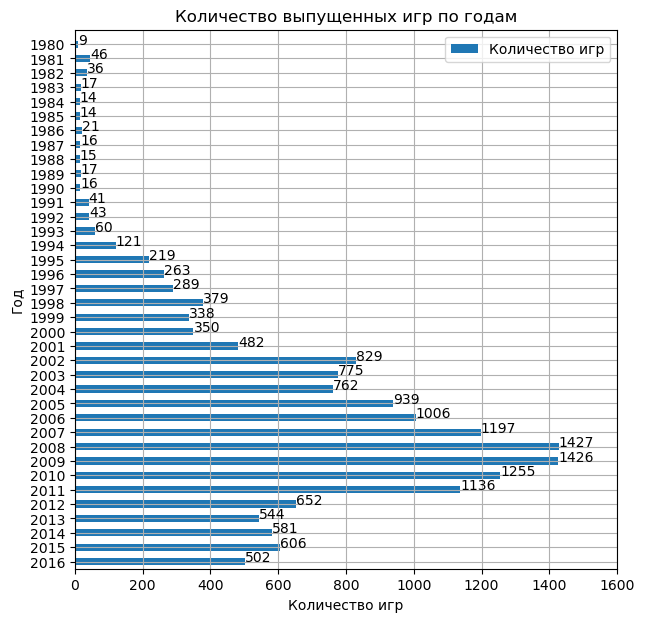

In [81]:
year_of_release_counts = data['year_of_release'].value_counts().sort_index(ascending=False)
year_of_release_counts.plot(kind='barh', figsize=(7, 7), grid=True, label='Количество игр')
for index, value in enumerate(year_of_release_counts):
        plt.text(value, index, str(value))
plt.ylim(-0.5, 37)
plt.xlim(0, 1600)
plt.title("Количество выпущенных игр по годам")
plt.xlabel("Количество игр")
plt.ylabel("Год")
plt.legend()
plt.show()

*Из графика мы видим, что рынок видеоигр постепенно развивался, а все ключевые моменты индустрии сказывались на количестве выпускаемых игр. Период с 1980 по 1982 называют рассветом домашнего гейминга. За ним следует 1983 - 1985, который ознаминовали кризисом. До 90х годов рынок находился в стогнации, приходил в себя, с середины 90х начался новый рассвет. Мы видим, что ежегодно количество выпускаемых игр только росло, прийдя к пику в 2008, а уже с 2009 года наблюдается снижение производства игр, это связано с выходом iphone 3g и смартфонов на android, развитием мобильного гейминга. 2012 - 2013 год это период появления микротранзакций, с этого момента разработчка стало не выгодно делать много игр, стало прибыльнее делать игры с внутренними платежами(игры-сервисы), эту тенденцию мы также видим на графике.*

**С выходом новых игр актуальность старых теряется, направленность рынка на игры сервисы тоже дает свои, плоды. Можно предположить, что в данных за весь период не будет необходимости, а актуальный период для прогназирования на 2017 год -- это промежуток с 2012 по 2016 годы.**

### Характерный срок жизни консолей

* Сделаем рейтинг топ 5 консолей

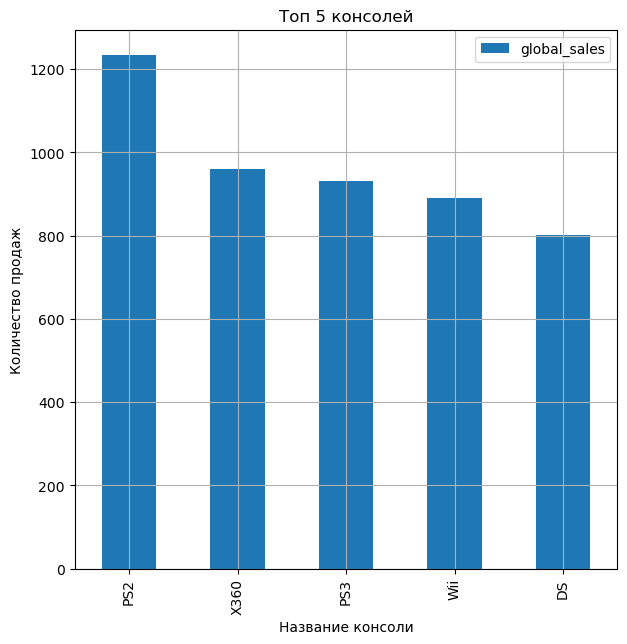

In [85]:
# Отбираем топ 5 консолей по продажам
data.pivot_table(index='platform', values='global_sales', aggfunc='sum')\
.sort_values(by='global_sales', ascending=False).head()\
.plot(kind='bar', figsize=(7, 7), grid=True)
plt.title("Топ 5 консолей")
plt.xlabel("Название консоли")
plt.ylabel("Количество продаж")
plt.legend()
plt.show()

* Сделаем сводные таблицы относительно количества продаж по годам. Отберем консоли по производителю. Построим графики.

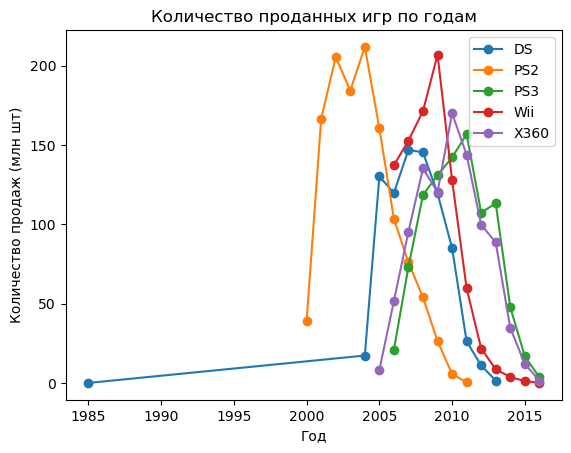

In [87]:
# Делаем сводные таблицы и строим графики
ps2 = data[data.platform == 'PS2'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
ds = data[data.platform == 'DS'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
ps3 = data[data.platform == 'PS3'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
wii	= data[data.platform == 'Wii'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
xbox = data[data.platform == 'X360'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');

plt.plot(ds, marker='o', label='DS')
plt.plot(ps2, marker='o', label='PS2')
plt.plot(ps3, marker='o', label='PS3')
plt.plot(wii, marker='o', label='Wii')
plt.plot(xbox, marker='o', label='X360')
plt.title("Количество проданных игр по годам")
plt.xlabel("Год")
plt.ylabel("Количество продаж (млн шт)")
plt.legend()
plt.show()

**Видиим аномалию в датах релиза DS**

In [89]:
#проверяем
data[data.platform == 'DS'].sort_values(by='year_of_release').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score,rating
15704,Strongest Tokyo University Shogi DS,DS,1985,Action,0.00,0.00,0.02,0.0,0.02,-1.0,-1.0,NR
13253,Cocoto Kart Racer,DS,2004,Racing,0.04,0.00,0.00,0.0,0.04,-1.0,-1.0,E
11339,Kenshuui Tendo Dokuta,DS,2004,Simulation,0.00,0.00,0.08,0.0,0.08,-1.0,-1.0,NR
4360,The Urbz: Sims in the City (all regions sales),DS,2004,Simulation,0.40,0.01,0.02,0.0,0.43,-1.0,-1.0,NR
7778,Daigasso! Band Brothers,DS,2004,Misc,0.00,0.00,0.19,0.0,0.19,-1.0,-1.0,NR


* Исправим на верную дату

In [91]:
data.loc[data.name == 'Strongest Tokyo University Shogi DS', 'year_of_release'] = 2007

* Построим график снова

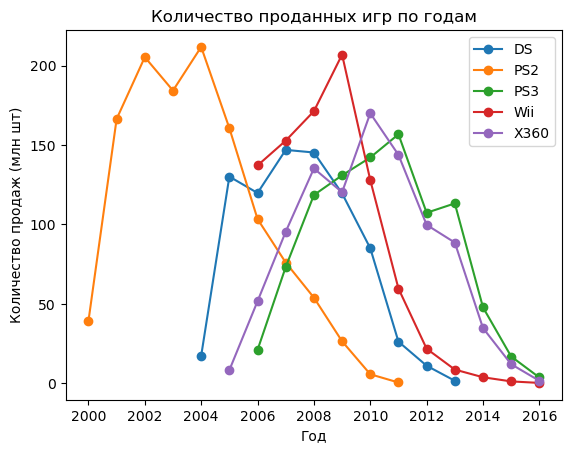

In [93]:
# Делаем сводные таблицы и строим графики
ps2 = data[data.platform == 'PS2'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
ds = data[data.platform == 'DS'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
ps3 = data[data.platform == 'PS3'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
wii	= data[data.platform == 'Wii'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
xbox = data[data.platform == 'X360'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');

plt.plot(ds, marker='o', label='DS')
plt.plot(ps2, marker='o', label='PS2')
plt.plot(ps3, marker='o', label='PS3')
plt.plot(wii, marker='o', label='Wii')
plt.plot(xbox, marker='o', label='X360')
plt.title("Количество проданных игр по годам")
plt.xlabel("Год")
plt.ylabel("Количество продаж (млн шт)")
plt.legend()
plt.show()

**На графике видно, что некоторые консоли живут дольше, чем другие, также иногда консоли переживают несколько пиков продаж, попробуем расчитать несколько вариантов продолжительности жизни консоли.**

* Медианное время жизни консоли

In [96]:
time_life = data[data['platform'].isin(['PS2', 'DS', 'PS3','Wii', 'X360'])].pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'median']).reset_index()
time_life['life'] = time_life['median'] - time_life['min'] + 1 
time_life['life'].median()

6.0

**Данный срок кажется достаточно коротким, показатель в десятки миллинов продаж стабильно держиться более 6 лет, но именно этот период приносит наибольшую прибыль**

* Посчитаем медиану общей продолжительности жизни консоли

In [100]:
time_life = data[data['platform'].isin(['PS2', 'DS', 'PS3','Wii', 'X360'])].pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 
time_life['life'].median()

11.0

**Данное число хорошо отображает медианную продолжительность жизни консоли, с года первого релиза до последнего**

In [102]:
# Комментарий ревьюера
temp = data.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

### Анализ контрольного периода

* Создадим датафрейм, который будет содержать данные за контрольный период с 2012 года по 2016.

In [105]:
#создаем датафрейм
data_control_period = data[data.year_of_release >= 2012].reset_index(drop= True)

In [106]:
# проверим его
data_control_period.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score,rating
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,21.05,97.0,8.2,M
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,16.27,97.0,8.1,M
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,14.63,-1.0,-1.0,NR
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,14.60,-1.0,-1.0,NR
4,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,13.79,83.0,5.3,M


In [107]:
#смотрим общую информацию
data_control_period.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2885 entries, 0 to 2884
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2885 non-null   object 
 1   platform         2885 non-null   object 
 2   year_of_release  2885 non-null   Int64  
 3   genre            2885 non-null   object 
 4   na_sales         2885 non-null   float64
 5   eu_sales         2885 non-null   float64
 6   jp_sales         2885 non-null   float64
 7   other_sales      2885 non-null   float64
 8   global_sales     2885 non-null   float64
 9   critic_score     2885 non-null   float64
 10  user_score       2885 non-null   float64
 11  rating           2885 non-null   object 
dtypes: Int64(1), float64(7), object(4)
memory usage: 273.4+ KB


**Мы создали датафрейм, который содержит 2899 строк и не имеет пропусков**

* Посмотрим топ продаж начиная с 2012 года

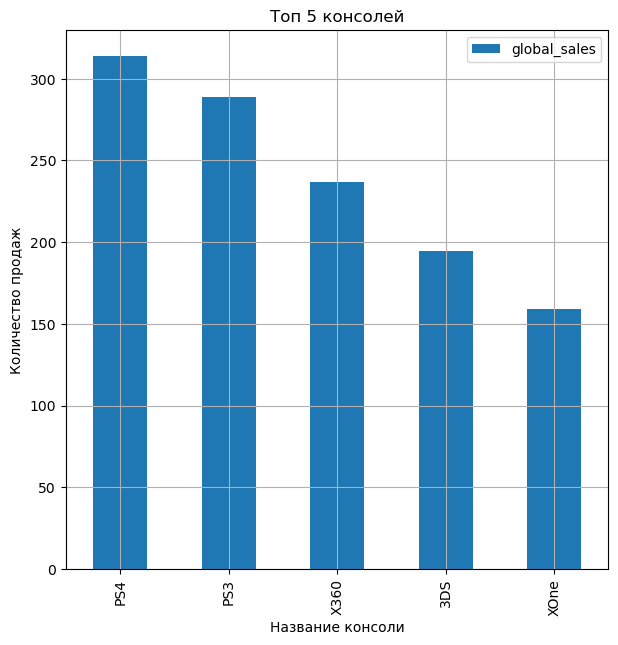

In [110]:
data_control_period.pivot_table(index='platform', values='global_sales', aggfunc='sum')\
.sort_values(by='global_sales', ascending=False).head()\
.plot(kind='bar', figsize=(7, 7), grid=True)
plt.title("Топ 5 консолей")
plt.xlabel("Название консоли")
plt.ylabel("Количество продаж")
plt.legend()
plt.show()

* Сделаем сводные таблицы относительно количества продаж по годам. Построим графики.

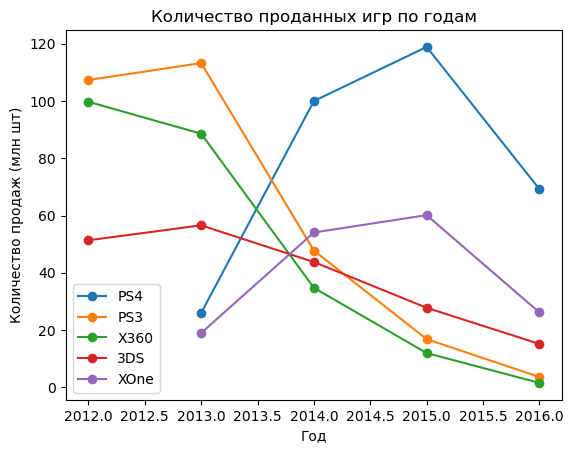

In [112]:
ps4 = data_control_period[data_control_period.platform == 'PS4'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
ps3 = data_control_period[data_control_period.platform == 'PS3'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
x360 = data_control_period[data_control_period.platform == 'X360'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
ds3 = data_control_period[data_control_period.platform == '3DS'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');
xone = data_control_period[data_control_period.platform == 'XOne'].pivot_table(index='year_of_release', values='global_sales', aggfunc='sum');

plt.plot(ps4, marker='o', label='PS4')
plt.plot(ps3, marker='o', label='PS3')
plt.plot(x360, marker='o', label='X360')
plt.plot(ds3, marker='o', label='3DS')
plt.plot(xone, marker='o', label='XOne')
plt.title("Количество проданных игр по годам")
plt.xlabel("Год")
plt.ylabel("Количество продаж (млн шт)")
plt.legend()
plt.show()

* Исходя из данных данных мы можем прогнозировать:
  1. На PS4 и XOne придутся самые большие продажи в 2017 году, не смотря на то, что продажи на этих консолях падают, исходя из данных прошлых лет, возможен повторный рост популярности, иногда привышающий первый пик. Также стоит учесть, что данные модели еще несколько лет будут оставать флагманами до выхода консолей следующего поколения. Предположим, что PS4 займет первое место с результатом около 60 млн продаж, а XOne второе место с результатом около 30 млн продаж в 2017 году.
  2. PS3 и X360 хоть и принесли много продаж в период 2012 - 2016 год, но большая часть этих продаж пришлась на 2012 и 2013 годы, сейчас продажи на данных консолях стремительно падают.
  3. 3DS Выглядит перспективно, несмотря на постепенное падение продаж, оно достаточно линейно и можно спрогнозировать, что будет в районе 15 млн.

### Диаграмма размаха продаж

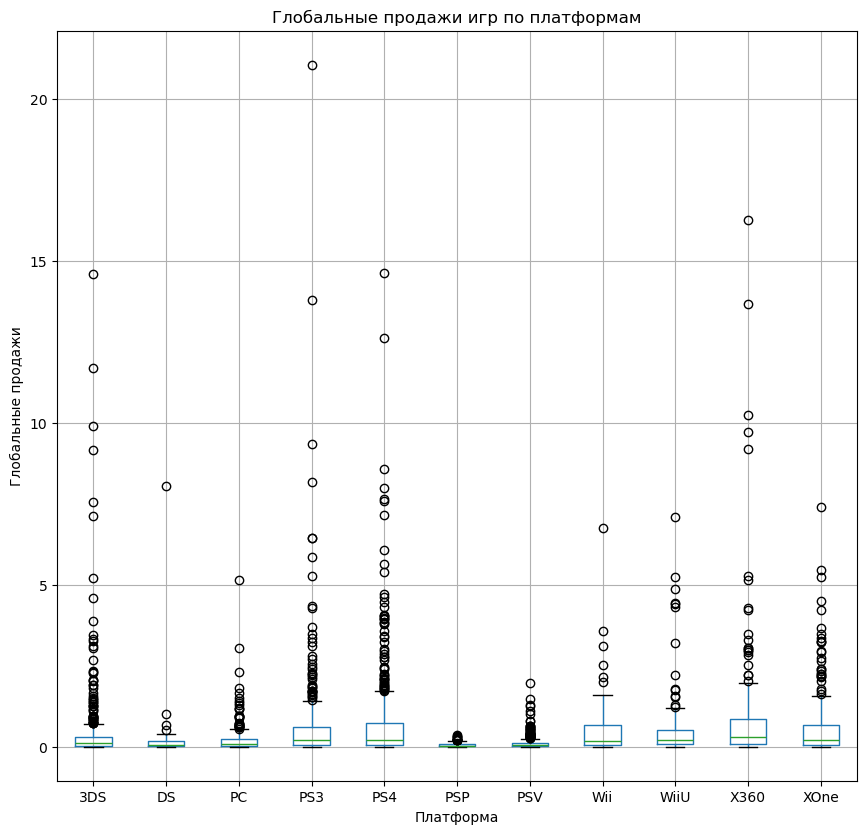

In [116]:
data_control_period.boxplot(column='global_sales', by='platform', figsize=(10, 10))
plt.title('Глобальные продажи игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи')
plt.suptitle('')
plt.show()

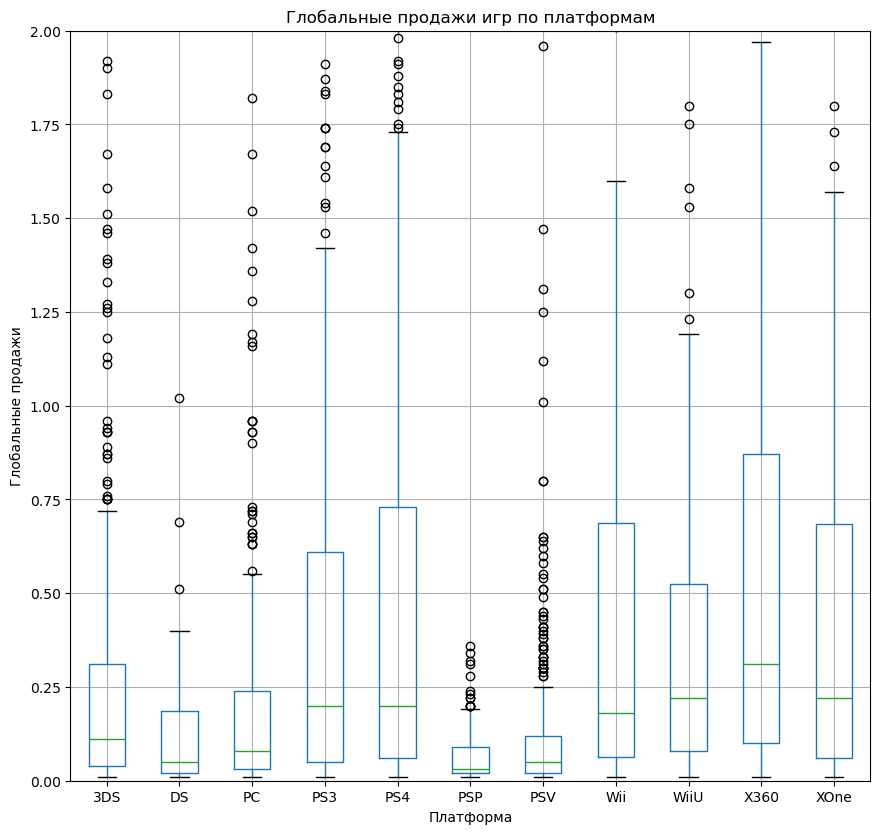

In [117]:
data_control_period.boxplot(column='global_sales', by='platform', figsize=(10, 10))
plt.ylim(0, 2)
plt.title('Глобальные продажи игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи')
plt.suptitle('')
plt.show()

* Медиана продаж у PS3, PS4 и XOne находится на одном уровне, в райное 0.2 млн продаж за игру, при этом максимальная граница продаж разная, у Xone -- чуть больше 1.5млн, у PS3 -- чуть меньше 1.5млн, у PS4 -- примерно 1.7 млн. X360 выделается медианой чуть более 0.3 млн продаж и верхней границей около 2 млн, при этом мы видим, что у остальных платформ в значении около 2 млн имеется большое количество выбросов. 3DS в наименее выиграшной позиции, медиана по играм здесь чуть более 0.1 млн, а максимальная граница около 0.7 млн, но при этом она также имеет проекты, которые продавались уникально большими тиражами в несколько миллионов. Так мы наблюдаем большое количество выбросов у популярных платформ, есть игры которые продавались тиражами в несколько миллионов и даже более десяти миллионов.

### Влияние оценок на продажи

* Построим диаграмму рассеяния продаж по оценкам критиков, исключитим из данных строки с нулевыми значениями оценок.

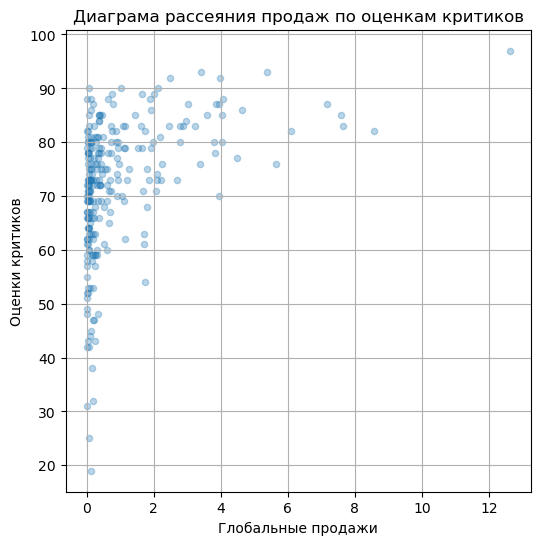

In [121]:
data_control_period[(data_control_period.platform == 'PS4') & (data_control_period.critic_score > -1)]\
.plot(x='global_sales', y='critic_score', kind='scatter', alpha=0.3, figsize=(6, 6), grid=True);
plt.title('Диаграма рассеяния продаж по оценкам критиков')
plt.xlabel('Глобальные продажи')
plt.ylabel('Оценки критиков')
plt.show()

**На диаграмме рассеивания, мы можем наблюдать, что явной кореляции между оценками критиков и количетвом продаж нет, но также видно, что все игры, которые проданы тиражем от 2млн копий, имели рейтинг критиков более 70.**

In [123]:
data_control_period[(data_control_period.platform == 'PS4') & (data_control_period.critic_score > -1)]['global_sales'].corr(data['critic_score'])

0.03230423324238323

**Коэффициент корреляции доказывает наше предположение, зависимость продаж от оценок в районе 0,032, что соотвествует слабой корелляции**

* Построим диаграмму рассеяния продаж по оценкам пользователей, исключитим из данных строки с нулевыми значениями оценок.

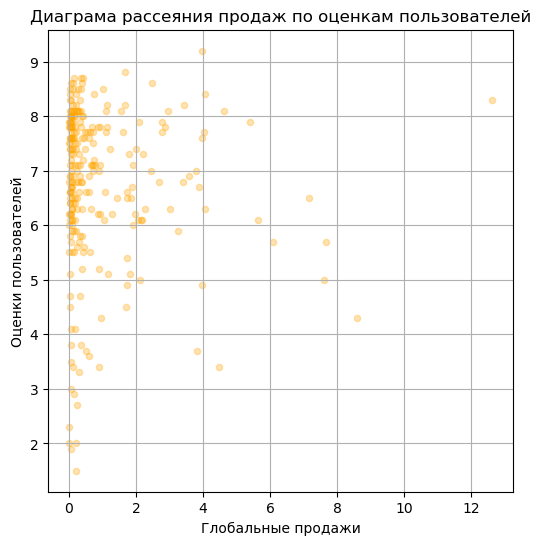

In [126]:
data_control_period[(data_control_period.platform == 'PS4') & (data_control_period.user_score > -1)]\
.plot(x='global_sales', y='user_score', kind='scatter', color = 'orange', alpha=0.3, figsize=(6, 6), grid=True);
plt.title('Диаграма рассеяния продаж по оценкам пользователей')
plt.xlabel('Глобальные продажи')
plt.ylabel('Оценки пользователей')
plt.show()

**На диаграмме рассеивания, мы можем наблюдать, что явной кореляции между оценками пользователей и количетвом продаж нет. Она даже менее выражена, чем в случае с оценками от критиков. Игры с высокой оценкой пользователей не всегда продаются лучше, чем с более низкой оценкой.**

In [128]:
data_control_period[(data_control_period.platform == 'PS4') & (data_control_period.user_score > -1)]['global_sales'].corr(data['user_score'])

0.0013659453220451919

**Коэффициент корреляции доказывает наше предположение, зависимость продаж от оценок в районе 0,013, что соотвествует очень слабой корелляции**

### Вывод о других платформах

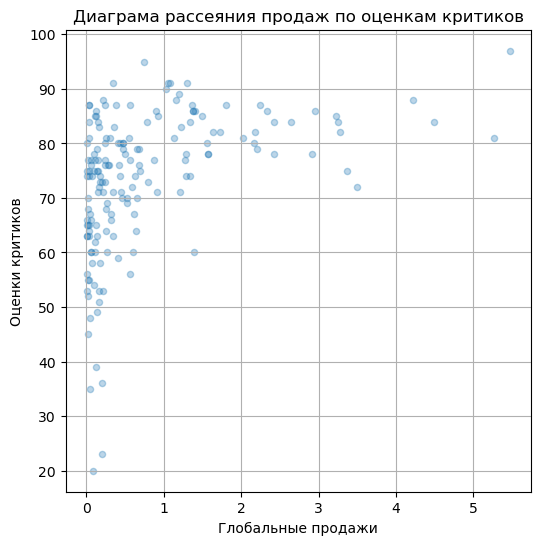

In [131]:
data_control_period[(data_control_period.platform == 'XOne') & (data_control_period.critic_score > -1)]\
.plot(x='global_sales', y='critic_score', kind='scatter', alpha=0.3, figsize=(6, 6), grid=True);
plt.title('Диаграма рассеяния продаж по оценкам критиков')
plt.xlabel('Глобальные продажи')
plt.ylabel('Оценки критиков')
plt.show()

**На диаграмме рассеивания, прослеживается слабая корреляция оценок к продажам, особенно для игр с оценкой больше 70. Расчитаем корреляцию**

In [133]:
data_control_period[(data_control_period.platform == 'XOne') & (data_control_period.critic_score > -1)]['global_sales'].corr(data['critic_score'])

0.209619526481401

**Коэффициент кореляци 0.2 показывает, что есть слабая кореляция между оценками и продажами**

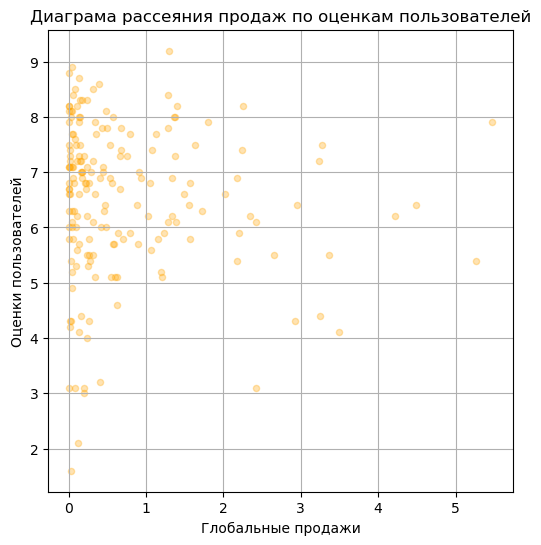

In [135]:
data_control_period[(data_control_period.platform == 'XOne') & (data_control_period.user_score > -1)]\
.plot(x='global_sales', y='user_score', kind='scatter', color = 'orange', alpha=0.3, figsize=(6, 6), grid=True);
plt.title('Диаграма рассеяния продаж по оценкам пользователей')
plt.xlabel('Глобальные продажи')
plt.ylabel('Оценки пользователей')
plt.show()

**На диаграмме рассеивания, корреляция почти не прослеживается**

In [137]:
data_control_period[(data_control_period.platform == 'XOne') & (data_control_period.user_score > -1)]['global_sales'].corr(data['user_score'])

0.14515554850660267

**Коэффициент кореляци 0.14 показывает, что присутствует очень слабая кореляция между оценками и продажами**

*Изучим диаграммы и расчитаем коэффициент корреляци для 3DS 

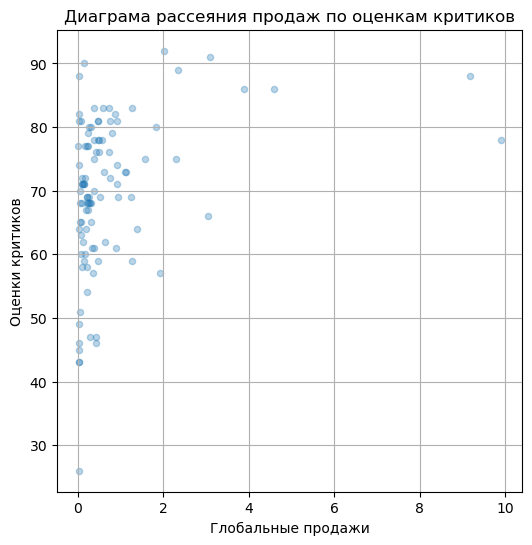

In [140]:
data_control_period[(data_control_period.platform == '3DS') & (data_control_period.critic_score > -1)]\
.plot(x='global_sales', y='critic_score', kind='scatter', alpha=0.3, figsize=(6, 6), grid=True);
plt.title('Диаграма рассеяния продаж по оценкам критиков')
plt.xlabel('Глобальные продажи')
plt.ylabel('Оценки критиков')
plt.show()

In [141]:
data_control_period[(data_control_period.platform == '3DS') & (data_control_period.critic_score > -1)]['global_sales'].corr(data['critic_score'])

0.05103966998703653

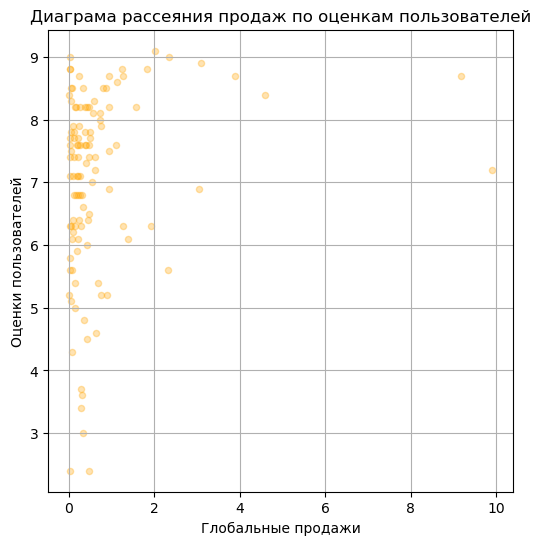

In [142]:
data_control_period[(data_control_period.platform == '3DS') & (data_control_period.user_score > -1)]\
.plot(x='global_sales', y='user_score', kind='scatter', color = 'orange', alpha=0.3, figsize=(6, 6), grid=True);
plt.title('Диаграма рассеяния продаж по оценкам пользователей')
plt.xlabel('Глобальные продажи')
plt.ylabel('Оценки пользователей')
plt.show()

In [143]:
data_control_period[(data_control_period.platform == '3DS') & (data_control_period.user_score > -1)]['global_sales'].corr(data['user_score'])

0.046609117875541624

**Как и в предыдущих примерах, зависимость оценок к продажам очень слабая. 0.05 для критиков и 0.046 для пользователей** 

* Мы видим, что показатель корреляции оценок от критиков к глобальным продажам достаточно слабая, на платформах 3DS и PS4 она очень слабая, для XOne она просто слабая. Корреляция оценок пользователей к продажам очень слабая на всех проверенных платформах.
* В качестве рекомендации, я бы предложил добавить столбец с бюджетом на рекламную компанию. И сравнил бы кореляцию продаж относительно бюджета на рекламу, есть основание пологать, что кореляции в данном случае будет более высокой.

### Распределение игр по жанрам

* Расчитаем количество выпущенных игр по жанрам

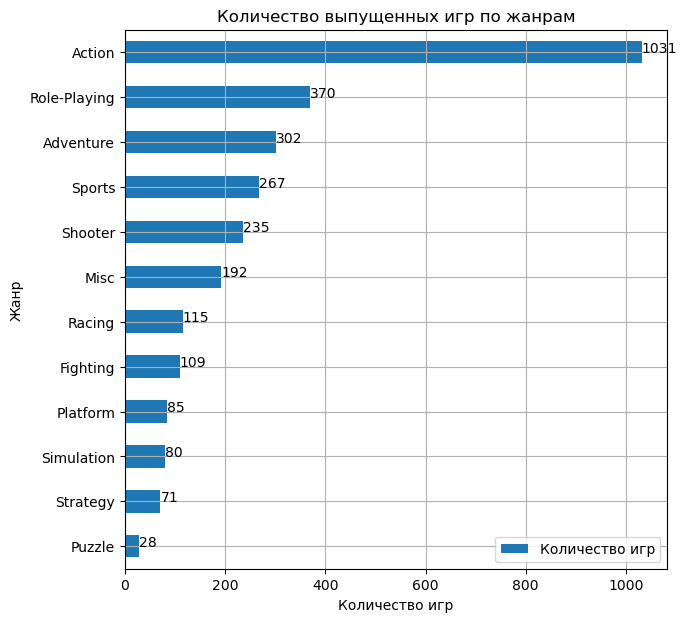

In [149]:
data_genre = data_control_period['genre'].value_counts(ascending=True)
data_genre.plot(kind='barh', figsize=(7, 7), grid=True, label='Количество игр')
for index, value in enumerate(data_genre):
        plt.text(value, index, str(value))
plt.title("Количество выпущенных игр по жанрам")
plt.xlabel("Количество игр")
plt.ylabel("Жанр")
plt.legend()
plt.show()

**Игр в жанре "Action" выпускается несоразмерно больше, чем в других жанрак, 1031 игра за выбранный период, на втором месте 'Role-Playing' с 370 играми, 'Adventure' на третьем месте с 302 выпушенными играми, 'Sports' на 4 месте и имеет 267 выпущенных игр, пятерку замыкает жанр 'Shooter' с 235 играми.**

* Посчитаем количество продаж по жанрам

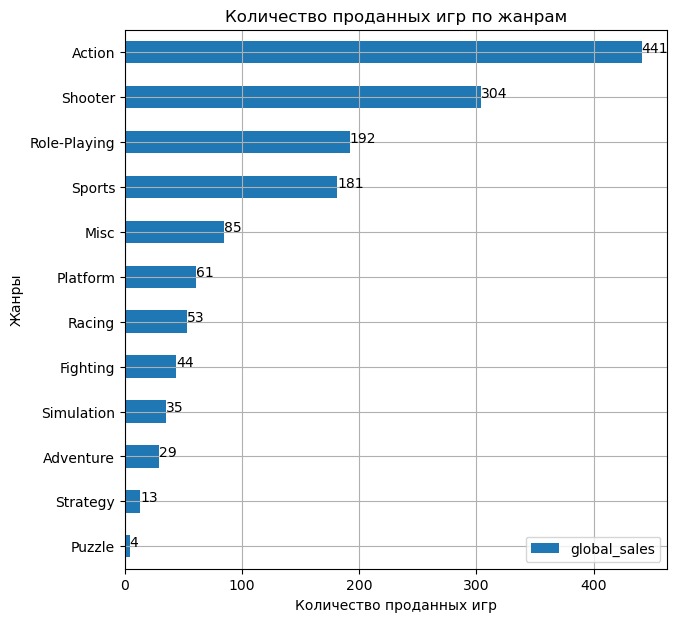

In [152]:
data_genre_sales = data_control_period.pivot_table(index='genre', values='global_sales', aggfunc='sum').sort_values(by='global_sales').astype('int')
ax = data_genre_sales.plot(kind='barh', figsize=(7, 7), grid=True)
for index, value in enumerate(data_genre_sales['global_sales']):
    ax.text(value, index, str(value))
plt.title("Количество проданных игр по жанрам")
plt.xlabel("Количество проданных игр")
plt.ylabel("Жанры")
plt.legend(loc=4)
plt.show()

**Игры в жанре "Action" лидирую по количеству продаж 441 млн игр за период, что не удивительно, ведь их выпускается очень много, игры в жанре 'Shooter' на этот раз уже занимают второе место с продажами в количестве 304 млн за период, на третьем месте второй по количеству выпущенных проектов жанр -- 'Role-Playing' с продажами в размере 192 млн. Можно сказать, что жанры с наибольшим количеством продаж входят в топ 5 по количеству выпущенных игр**

* Рассчитаем среднее количество продаж игр относительно жанра

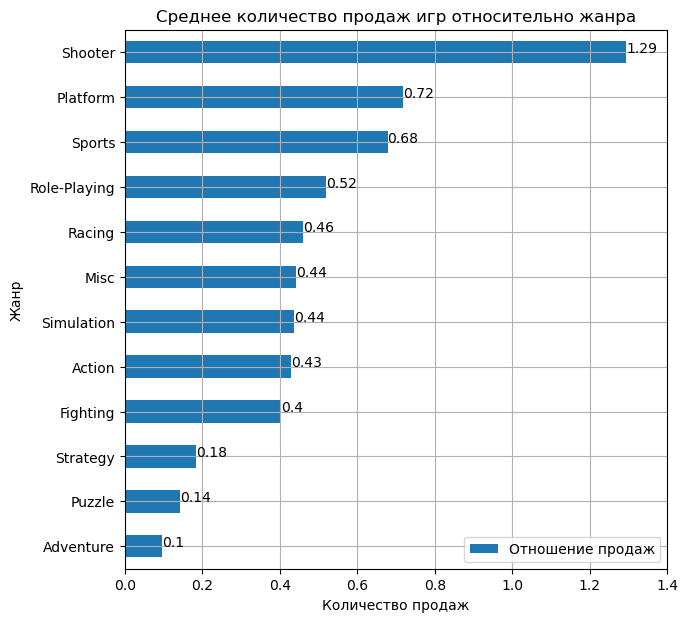

In [157]:
date_genre_profit = data_genre_sales['global_sales']/data_genre
date_genre_profit = date_genre_profit.sort_values(ascending=True)
date_genre_profit.plot(kind='barh', figsize=(7, 7), grid=True, label='Отношение продаж')
for index, value in enumerate(date_genre_profit):
    plt.text(value, index, str(round(value, 2)))
plt.xlim(0, 1.4)
plt.title("Среднее количество продаж игр относительно жанра")
plt.xlabel("Количество продаж")
plt.ylabel("Жанр")
plt.legend()
plt.show()

* Мы можем наблюдать, что рейтинг снова поменялся:
1. 'Shooter' -- 1.29 млн продаж
2. 'Platform' -- 0.72 млн продаж
3. 'Sports' -- 0.68 млн продаж
4. 'Role-Playing' -- 0.52 млн продаж

**Мы выделили самые популярные жанры, в среднем игры в которых продаются тиражем более 500 000. Жанр 'Shoter' выделяется среди остальных, ведь игры в этом жанре в среднем продаются более чем одни миллионом копий. Игр в жанре 'Adventure' продается всего около 100 000 в среднем. А жанр Action находится среди жанров, которые немного не дотягивают до полумилиона копий на игру.**

* Для исследовательского анализа данных мы получили следующие цели и задачи:
1. Оценка важности данных за периоды выпуска игр  
2. Оперделение срока жизни консоли
3. Определение актуального периода данных
4. Определение потенциально прибыльных консолей на 2017 год
5. Описание продаж по ящику с усами
6. Оценка влияния критиков на продажи
7. Определение самых продаваемых жанров

* По окончанию исследовательского анализа данных мы выявили:

1. За последние 5 лет количество ежегодно выпускаемых игр снизилось, в связи с ростом популярности игр-сервисов, стоит сделать упор на такие игры.
2. Срок жизни консоли ~ 11 лет, срок получения максимально прибыль ~ 6 лет
3. Актуальный период оценки данных 2012-2016 год
4. Потенциально самые прибыльные консоли на 2017 год -- это PS4, XOne и 3DS
5. Медианное значение продаж для популярных консолей около 200 000 копий на игру
6. Влияние оценок критиков, выше, чем влияние оценок пользователей, но оценки не являются основным показателем успеха продаж
7. Самые продаваемые жанры -- Action и Shooter, самые продаваемые жанры на одну игру -- Shooter и Platform

* Рекомендации:

Для оценки успешности игры, возомжно стоит учитывать бюджет на рекламную компанию, есть догадка, что он влияет гораздо сильнее, чем оценки.
Также можно учитывать, например, количество просмотров на различных онлайн-плафтормах, видео-хостинги, интернет издания и т.д.

## Шаг 4. Портрет пользователя в разных регионах

### Самые популярные платформы

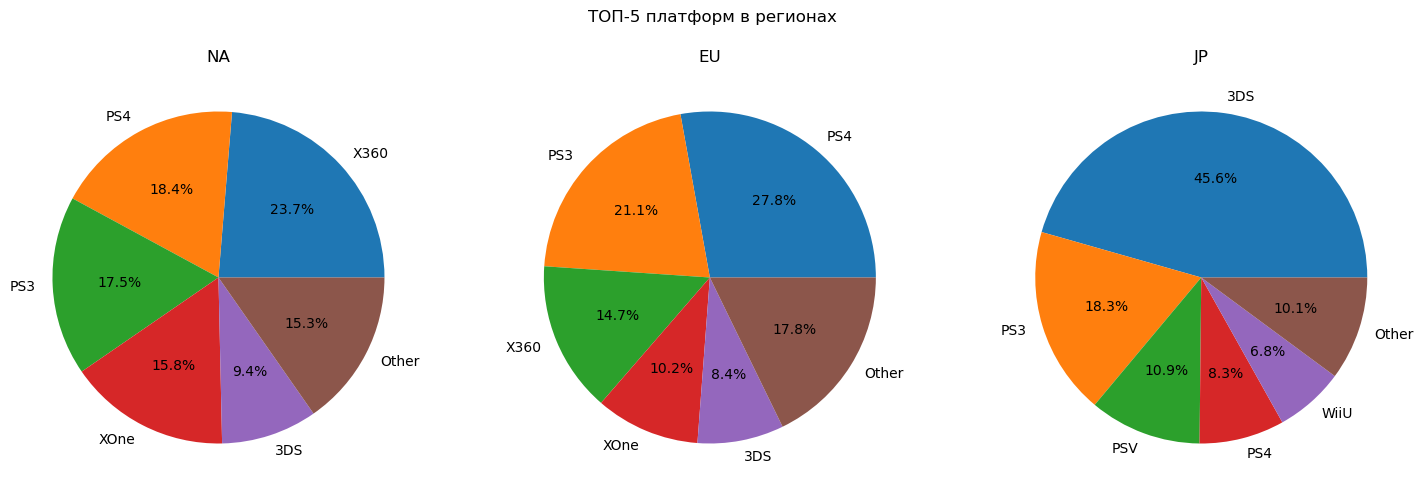

In [165]:
parametr = 'platform'  
def pie_chart(df, parametr='platform'):  # В функцию передаем датасет и имя колонки
    region = df.columns[4:7]              # Создаем список регионов из названий колонок
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    if parametr == 'platform':
        fig.suptitle('ТОП-5 платформ в регионах')
    elif parametr == 'genre':
        fig.suptitle('ТОП-5 жанров в регионах')
    elif parametr == 'rating':
        fig.suptitle('Влияние рейтинга ESRB на продажи в регионах')

    for r in range(len(region)):
        if parametr != 'rating':  # Формируем топ-5 и группу "другие"
            df_r = (df.groupby(parametr)[region[r]].sum().reset_index()
                    .sort_values(region[r], ascending=False, ignore_index=True)[:5])
            
            # Объединяем остальные продажи в 'Other'
            other_value = df[region[r]].sum() - df_r[region[r]].sum()
            df_r = pd.concat([df_r, pd.DataFrame({parametr: ['Other'], region[r]: [other_value]})], ignore_index=True)
        else:  # Для возрастного рейтинга строим диаграммы по всем значениям
            df_r = (df.groupby(parametr)[region[r]].sum().reset_index()
                    .sort_values(region[r], ascending=False, ignore_index=True))

        # Проверка на пустые данные
        if df_r.empty:
            continue
        
        axs[r].pie(df_r[region[r]], labels=df_r[parametr], autopct='%1.1f%%')
        axs[r].set_title(df_r.columns[1].split('_')[0].upper())
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Добавление пространства для заголовка
    plt.show()

# Выводим диаграммы
pie_chart(data_control_period, parametr)

*Топ консолей в NA:*
1. X360 - 23.7% рынка
2. PS4 - 18.4% рынка
3. PS3 - 17.5% рынка
4. XOne - 15.8% рынка
5. 3DS - 9.4% рынка

*Топ консолей в EU:*
1. PS4 - 27.8% рынка
2. PS3 - 21.1% рынка
3. X360 - 14.7% рынка
4. XOne - 10.2% рынка
5. 3DS - 8.4% рынка

*Топ консолей в JP:*
1. 3DS - 45.6% рынка
2. PS3 - 18.3% рынка
3. PSV - 10.9% рынка
4. PS4 - 8.3% рынка
5. WiiU - 6.8% рынка

**Топ консолей в NA и EU досточно схожий, лидируют консоли от одних и тех же производителей, но в NA больше играют на X360, а в EU абсолютный лидер PS4. В регоине JP, абсолютно другая ситуация, на первом месте 3DS, портативная консоль, которая в других регионах занимает последнее место в ТОП-5, также в отличии от предыдущих регионов в списке лидеров есть PSV и WIIU, отличительной особенностью данных консолей, как и 3DS является портативность.**

### Самые популярные жанры 

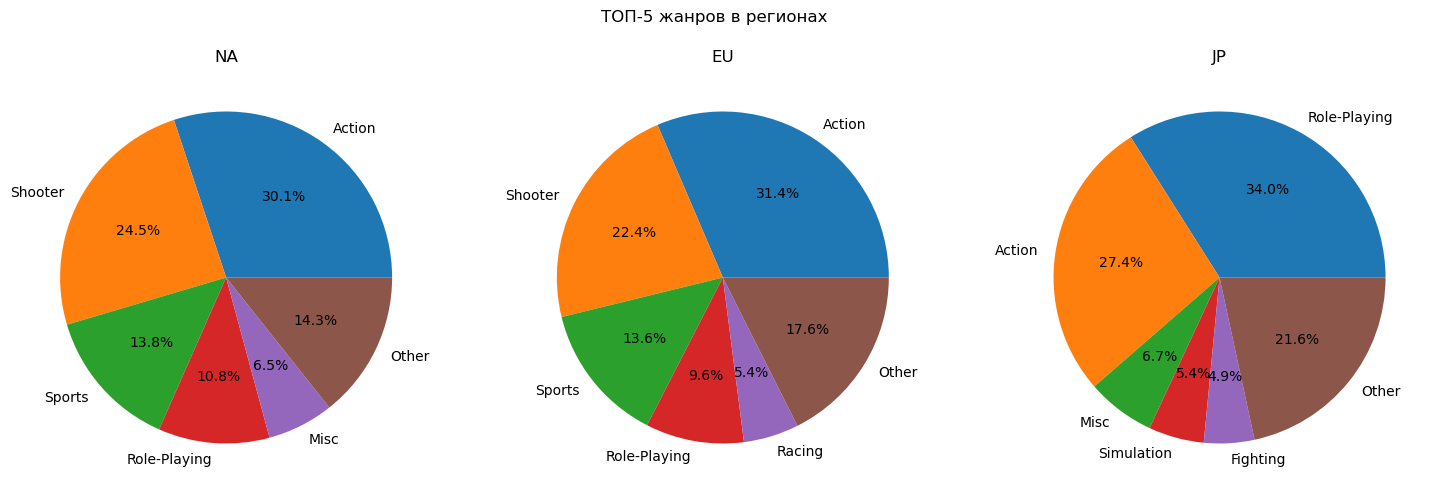

In [172]:
pie_chart(data_control_period, 'genre')   

*Топ жанров в NA:*
1. Action - 30.4% рынка
2. Shooter - 24.4% рынка
3. Sports - 13.7% рынка
4. Role-Playing - 10.8% рынка
5. Misc - 6.4% рынка

*Топ жанров в EU:*
1. Action - 31.84% рынка
2. Shooter - 22.3% рынка
3. Sports - 13.6% рынка
4. Role-Playing - 9.5% рынка
5. Racing - 5.4% рынка

*Топ жанров в JP:*
1. Role-Playing - 33.9% рынка
2. Action  - 27.4% рынка
3. Misc - 6.8% рынка
4. Simulation - 5.4% рынка
5. Fighting - 4.9% рынка

**В случае с жанрами мы видим, что в NA и EU снова схожа ситуация, Action, Shoter, Sports, Role-Playing лидриуют в списке любимых пользователями. Различны лишь последние места топ-5, в NA на первое место выходит Misc, а в EU пользователи чаще выбирают игры в жанре Racing. В JP есть 2 явных фаворита -- Role-Playin и Action, они занимают чуть более 60% рынка, остальные жанры имеют менее 7%.**

### Влияние рейтинга ESRB на продажи в регионе

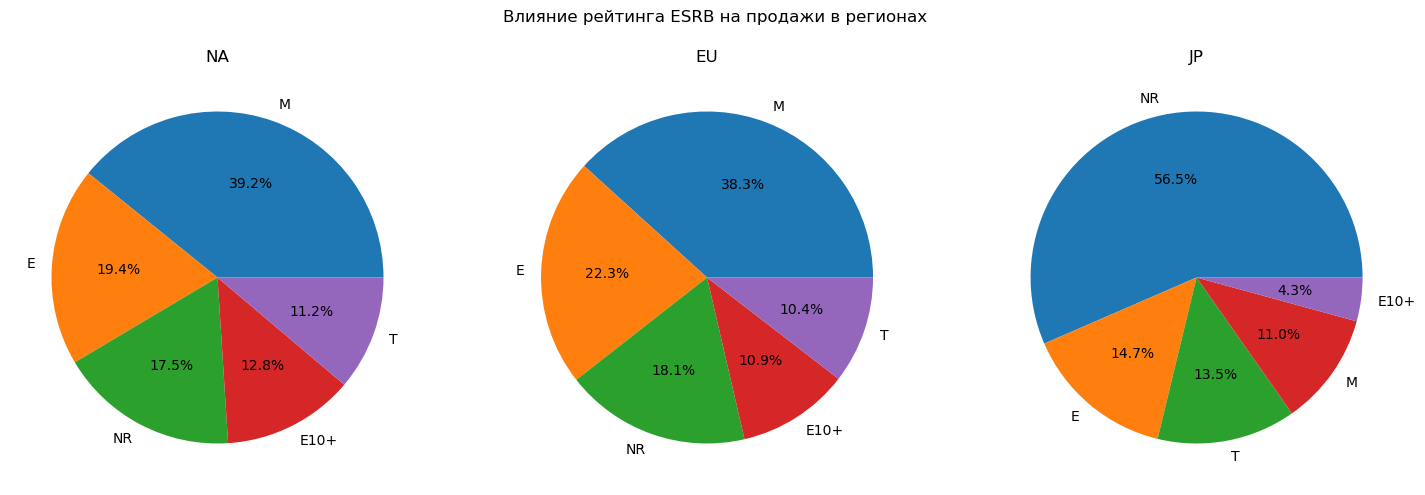

In [179]:
pie_chart(data_control_period, 'rating') 

**39% продаж из всех игр приходятся на рейтинг M, в соответсвии с категоризацией ESRB -- это игры для взрослых, на втором месте игры с рейтингом E -- игры для всех, игры, которые не имеют классификации ESRB находятся на третьем месте. Исходя из данных можно сделать вывод, что в NA рейтинг ESRB влияет на выбор пользователей.**

**Ситуация в EU снова схожа с NA, есть небольшие различая в количестве процентов, которые не влияют на общее представление.**

**При оценки ситуации в JP, мы видим, что более 56.6% продаж приходятся на игры без рейтинга. На основе этих данных, можно сделать вывод, что продажи в JP не связаны с рейтингом ESRB.**

## Шаг 5. Проверка гипотез

### Гипотеза о рейтингах платформ

*Нам задно предположение, которое необходимо проверить: "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"*
Сформируем нулевую гипотезу:

Н0: Средняя оценка пользователя XOne и PC равны - исходя из условия, нам необходимо сравнить два средних рейтинга

Н1: Средняя оценка пользователя XOne и PC не равны - обратная равенству гипотеза
* Проверяем нулевую гипотезу, как двустроннюю гипотезу для средних двух генеральных совокупностей, потому что в условии требуется сравнть средние двух генеральные совокупностей, совокупность оценок пользовтелей для XOne и для PC


In [187]:
alpha = 0.05

results = st.ttest_ind(data_control_period[(data_control_period['platform'] =='XOne') & (data_control_period['user_score'] > -1)]['user_score']\
                       , data_control_period[(data_control_period['platform'] =='PC') & (data_control_period['user_score'] > -1)]['user_score'], equal_var=False)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.5489537965134912
Нет оснований отвергнуть нулевую гипотезу


**При p-value: 0.54 у нас нет оснований для отвержения нулевой гипотезы, соотвесвенно мы можем утверждать, что оценки пользоватлей XOne и PC скорее равны.**

* Проверим оценки пользователей для XOne и PC

In [191]:
data_control_period[(data_control_period['platform'] =='XOne') & (data_control_period['user_score'] > -1)]['user_score'].mean()

6.521428571428572

In [193]:
data_control_period[(data_control_period['platform'] =='PC') & (data_control_period['user_score'] > -1)]['user_score'].mean()

6.4286407766990274

**При таких значениях мы не можем отвергать факт, того что оценки пользователей скорее равны**

### Гипотеза о рейтингах жанров

*Нам задно предположение, которое необходимо проверить: "Средние пользовательские рейтинги жанров Action и Sports разные."*
Сформируем нулевую гипотезу:

Н0: Средняя оценка пользователя для жанра Action и Sports равны

Н1: Средняя оценка пользователя для жанров Action и Sports не равны

* Проверяем альтернативную гипотезу, как двустроннюю гипотезу для средних двух генеральных совокупностей, потому что в условии требуется сравнть средние двух генеральные совокупностей, совокупность оценок пользовтелей для жанра Action и для Sports

In [198]:
alpha = 0.05

results = st.ttest_ind(data_control_period[(data_control_period['genre'] =='Action')\
                       & (data_control_period['user_score'] > -1)]['user_score']\
                       , data_control_period[(data_control_period['genre'] =='Sports')\
                       & (data_control_period['user_score'] > -1)]['user_score'], equal_var=True)

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.804523380462917e-26
Отвергаем нулевую гипотезу


**При таком значении p-value, мы отвергаем нулевую гипотезу, соотвесвенно мы можем утверждать, что оценки пользоватлей для двух жанров не равны.**

* Проверим оценки пользователей для жанров Action и Sports

In [202]:
data_control_period[(data_control_period['genre'] =='Action')\
                       & (data_control_period['user_score'] > -1)]['user_score'].mean()

6.825047801147227

In [204]:
data_control_period[(data_control_period['genre'] =='Sports')\
                       & (data_control_period['user_score'] > -1)]['user_score'].mean()

5.455670103092784

**При таких значениях мы можем подтверждить факт того, что оценки пользователей разные.**

### Пояснение

1. Гипотезы были сформулированы, как двусторонние гипотезы равенства средних двух генеральных совокупностей. В первом и втором слуае мы сравнивали две генеральные совокупности совокупности. Первая гипотеза проверяет равнество средних оценок пользователей XOne и PC. Вторая гипотеза проверяет равнество средних оценок пользователей для жанров 'Action' и 'Sports'.
2. Для проверки гипотез мы использовали t-критерий для проверки равенства средних двух генеральный совокупностие, потому что:
* Он используется для сравнения средних двух независимых групп.
* Когда размеры выборок не обязательно одинаковые.
* Когда дисперсии выборок не обязательно одинаковые.

## Шаг 6. Вывод

*С целью планирования рекламной компании для интерент-магазина "Стримчик" на 2017 год мы получили данные о компьютерных играх*

* Для начала мы ознакомились с данными и провели их предобработку:
  1. Обработали названия столбцов
  2. Преобразовали типы данных
  3. Обработали пропуски
  4. Расчитали сумарные продажи по всем регионам
* Далее мы провели исследовательский анализ данных и получили следующую информацию:
  1. За последние 5 лет количество ежегодно выпускаемых игр снизилось, в связи с ростом популярности игр-сервисов, стоит сделать упор на такие игры.
  2. Срок жизни консоли ~ 11 лет, срок получения максимально прибыль ~ 6 лет
  3. Актуальный период оценки данных 2012-2016 год
  4. Потенциально самые прибыльные консоли на 2017 год -- это PS4, XOne и 3DS
  5. Медианное значение продаж для популярных консолей около 200 000 копий на игру
  6. Влияние оценок критиков, выше, чем влияние оценок пользователей, но оценки не являются основным показателем успеха продаж
  7. Самые продаваемые жанры -- Action и Shooter, самые продаваемые жанры на одну игру -- Shooter и Platform
* Выявили портреты пользователей:
  1. Пользователь из NA предпочитает X360, чаще играет в Action и Shooter, отдает предпочтение играм с рейтингом M
  2. Пользователь из EU предпочитает PS4, чаще играет в Action и Shooter, отдает предпочтение играм с рейтингом M
  3. Пользователь из JP предпочитает 3DS, чаще играет в Role-playing и Action, рейтинг игры не является ключевым при выборе
* Проверили гипотезы и выявили:
  1. Средняя оценка игр для пользователей XOne и PC скорее равны
  2. Средняя оценка игр от пользователей в жанре Action и PC скорее не равны
 
*Рекомендации:*
1. Возможно стоит в качестве сбора оценок использовать другой или несколько других источников, чтобы не терять данные об оценках пользователей, критиков и годах выпуска игр.
2. Как писал ранее, для оценки успешности игры, возомжно стоит учитывать бюджет на рекламную компанию, есть догадка, что он влияет гораздо сильнее, чем оценки.
3. Также можно учитывать, например, количество просмотров на различных онлайн-плафтормах, видео-хостинги, интернет издания и т.д.
4. Также, в связи с ростом количества игр-сервисов, стоит учитывать доход от микро-транзакций для оценки игр, он может привышать доход от продаж игры.
5. Рекламную компанию стоит проводить опираясь на 2 консоли: 
  * PS4, основные жанры Action и Shooter c рейтингом M, регион продвижения - EU, не стоит делать большой упор на оценки пользователей и критиков, но необходимо учесть, что игры с оценкой от критиков более 70 продаются лучше
  * XOne, основные жанры Action и Shooter c рейтингом M, регион продвижения - NA, также не стоит опираться на оценки пользователей и критиков, но необходимо учесть, что из всех проанализированных консолей, на Xone оценки критиков влияют сильнее всего, хоть и очень слабо